In [45]:
import json
import math
import requests
import requests
import numpy as np 
from io import BytesIO
import ipywidgets as widgets
from PIL import Image, ImageDraw
from IPython.display import display, clear_output
from pymongo.server_api import ServerApi
from pymongo.mongo_client import MongoClient
from tqdm.autonotebook import tqdm

## Database Connection

In [13]:
with open ("../credential.json") as file:
    credential = json.load(file)

# credential["mongo_db_key"]

client = MongoClient(credential["mongo_db_key"], server_api=ServerApi('1'))
db = client.myFirstDatabase
collection = db.collect_panorama
user_collection = db.users

## User Contribution

In [18]:
username = input("Enter username: ")

### User information

In [21]:
def timeConvert(num):
    hours = num / 60 
    rhours = math.floor(hours)
    minutes = (hours - rhours) * 60
    rminutes = math.floor(minutes)
    return f"{rhours} + hour(s) and + {rminutes} minutes(s)"


def get_user_info(username):
    # Create the query
    query = {
        'nickname': username
    }
    results = user_collection.find(query)

    for result in results:
        print(f"Username: {result['nickname']}")
        print(f"Email: {result['email']}")
        print(f"#label: {result['label']}")
        print(f"#scores: {result['score']}")
        print(f"#modify: {result['modify']}")
        print(f"#create: {result['create']}")
        print(f"#review: {result['review']}")
        print(f"#bonus: {result['bonus']}")
        print(f"Equivalent volunteer hours: {timeConvert(result['review'] + result["label"])}")




get_user_info(username)






Username: Jay
Email: 123@gmail.com
#label: 26
#scores: 15
#modify: 0
#create: 9
#review: 6
#bonus: 0
Equivalent volunteer hours: 0 + hour(s) and + 32 minutes(s)


### Check images

In [66]:
def get_all_related_documents(username):
    # Create the query
    query = {
        '$or': [
            {'creator': username},
            {'human_labels.name': username}
        ]
    }

    # Find the documents
    documents = collection.find(query)

    # Print the documents
    items = []
    for document in documents:
        # print(document)
        if document['url'] != "":
            items.append(document)

    return items 

def get_color(label_type):
    """Return the color for the given label type."""
    colors = {
        "door": "#F97F51",
        "knob": "#9AECDB",
        "ramp": "#EAB543",
        "stairs": "#D6A2E8"
    }
    return colors.get(label_type, "#FFFFFF") 

def get_img(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    return image

def draw_image_with_bbox(document, username):
    # Extract the URL of the image
    image_url = document['url']
    image = get_img(image_url)
    draw = ImageDraw.Draw(image)

    # Loop through the human_labels to find bounding boxes for the username
    for label in document['human_labels']:
        if label['name'] == username:
            for bbox_info in label['labels']:
                # Extract bounding box coordinates
                box = bbox_info['box']
                x = box['x']
                y = box['y']
                width = box['width']
                height = box['height']
                # Draw the bounding box on the image
                label_type = bbox_info['label']
                
                # Get the color for the label type
                color = get_color(label_type)
                draw.rectangle([(x, y), (x + width, y + height)], outline=color, width=2)

    # Display the image with bounding boxes
    return image

def get_random_documents(documents, random_num=30):
    documents_np = np.array(documents) 
    if len(documents) < random_num:
        choices = np.random.choice(len(documents), len(documents), replace=False).astype('int').tolist()
    else:
        choices = np.random.choice(len(documents), random_num, replace=False).astype('int').tolist()
    return documents_np[choices].tolist()

def draw_all_images(documents, username):
    results = []
    print("Adding bounding box to image: ")
    for document in tqdm(documents):
        results.append(draw_image_with_bbox(document, username))

    return results


def bytes_to_image(img):
    img_byte_arr = BytesIO()
    img.save(img_byte_arr, format='png')
    img_byte_arr = img_byte_arr.getvalue()
    return img_byte_arr


def display_images(images, n_cols=2):
    num_imgs = len(images)
    n_rows = math.ceil(num_imgs / n_cols)
    vbox = []
    index = 0
    for _ in range(n_rows):
        hbox = []
        for _ in range(n_cols):
            if index < num_imgs:
                img = widgets.Image(value=bytes_to_image(images[index]), format='png', width=640, height=640)
                hbox.append(img)
                index += 1
        vbox.append(widgets.HBox(hbox))
    display(widgets.VBox(vbox))

In [68]:
documents = get_all_related_documents(username)
ran_documents = get_random_documents(documents, random_num=10)


result = draw_all_images(ran_documents, username)

display_images(result, n_cols=3)

Adding bounding box to image: 


  0%|          | 0/10 [00:00<?, ?it/s]

## Check single image with object ID 

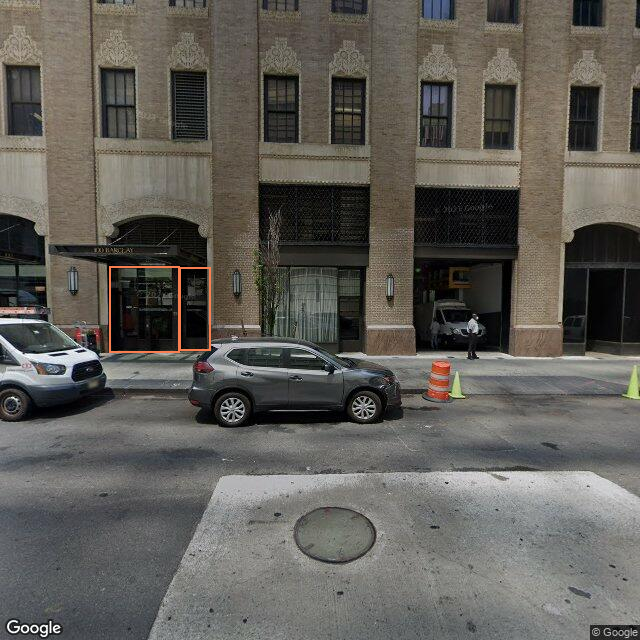

In [60]:
from PIL import ImageDraw
def get_image_with_imgid(img_id):
    # Create the query
    query = {
        'image_id': img_id
    }

    # Find the documents
    documents = collection.find(query)

    # Print the documents
    items = []
    for document in documents:
        # print(document)
        if document['url'] != "":
            items.append(document)

    return items 

def show_img(document, username=None):
    img_url = document['url']
    image = get_img(img_url)
    draw = ImageDraw.Draw(image)

    if username is None:
        label_info = document['human_labels'][0]
        for bbox_info in label_info['labels']:
            box = bbox_info['box']
            x = box['x']
            y = box['y']
            width = box['width']
            height = box['height']
            label_type = bbox_info['label']
            color = get_color(label_type)
            draw.rectangle((x, y, x + width, y + height), outline=color, width=2)
    else:
        for label in document['human_labels']:
            if label['name'] == username:
                for bbox_info in label['labels']:
                    box = bbox_info['box']
                    x = box['x']
                    y = box['y']
                    width = box['width']
                    height = box['height']
                    label_type = bbox_info['label']
                    color = get_color(label_type)
                    draw.rectangle((x, y, x + width, y + height), outline=color, width=2)
    return image



results = get_image_with_imgid("d72fda0c-ccc3-4fc0-aad3-44ecb919281e")
show_img(results[0], "kevin chau")